# ViT

paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)

## setup

In [235]:
import numpy as np
import math
from tqdm.notebook import tqdm
import einops
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
from enum import Enum, auto
from collections import defaultdict
from IPython.display import HTML
from sklearn.decomposition import PCA
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## data

In [2]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=True),
    batch_size=128,
    shuffle=True)

data_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=False),
    batch_size=128,
    shuffle=True)

## helpers

In [3]:
@torch.no_grad()
def accuracy(model, label='test', silent=False):
    model.eval()
    dataset = data_test if label == 'test' else data
    count = 0
    correct = 0
    for x, y in dataset:
        x, y = x.to(device), y.to(device)
        res = model(x).argmax(-1)
        count += len(x)
        correct += (res == y).float().sum()
    acc = correct / count
    if not silent: print(f'accuracy on {label:5}: {acc}')
    return acc

In [145]:
def plot(*args, n_col=None, figsize=None, block_size=3, labels=None):
    '''Plot images in a grid
    usage: plot(img1, img2, ...)
    optional: n_col=3, figsize=(12, 8), block_size=1

    img: torch.Tensor of shape (H, W) or (C, H, W) or [(H, W), ...] or [(C, H, W), ...]
    '''
    imgs = []
    for img in args:
        if isinstance(img, torch.Tensor):
            if img.dim() == 4: imgs.extend([img[i] for i in range(img.shape[0])])
            else: imgs.append(img)
        if isinstance(img, list) or isinstance(img, tuple):
            assert all(isinstance(i, torch.Tensor) and i.dim() == 3 for i in img)
            imgs.extend(img)

    # flatten channels
    imgs = [img.squeeze(0) if img.dim() == 3 else img for img in imgs]
    imgs = [img.detach().cpu() for img in imgs]

    if n_col is None: n_col = len(imgs)
    n_row = math.ceil(len(imgs) / n_col)
    if figsize is None: figsize = (n_col * block_size, n_row * block_size)
    # normalize ax to 2d array
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([[ax]])
    elif n_row == 1: ax = ax.reshape((1, -1))
    elif n_col == 1: ax = ax.reshape((-1, 1))
    # plot
    for i, img in enumerate(imgs):
        idx = (i // n_col, i % n_col)
        ax[idx].imshow(img)
        if labels and i < len(labels): ax[idx].set_title(labels[i])
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i // n_col, i % n_col)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        if i >= len(imgs): ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# test plot function
def test_plot(scale=1):
    imgs = next(iter(data))[0]
    plot(imgs[0], block_size=scale)
    plot(imgs[1], imgs[2], block_size=scale)
    plot(imgs[3], imgs[4], n_col=scale, block_size=scale)
    plot(imgs[5], imgs[6], imgs[7], n_col=2, block_size=scale)
    plot(imgs[:5], n_col=3, block_size=scale)

# test_plot()

## chunk images

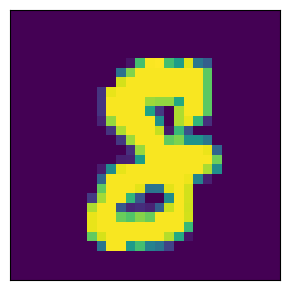

In [6]:
images = next(iter(data))[0][:2]
plot(images[0])

### manually

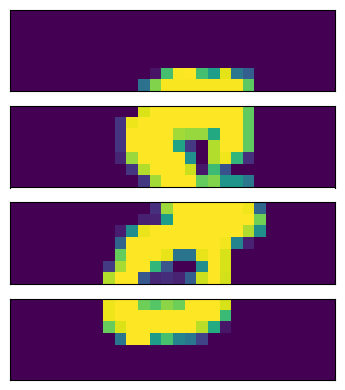

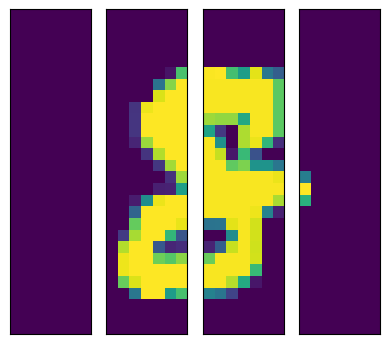

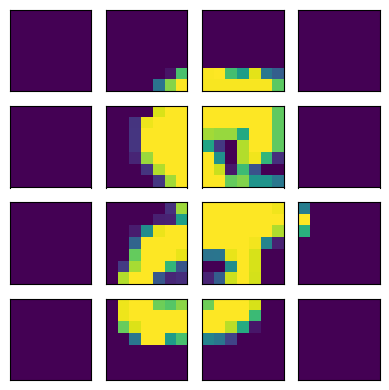

In [7]:
b, c, h, w = images.shape
# cut into horizontal strips
horizontal = images.view(b, c, 4, h // 4, w).permute(0, 2, 1, 3, 4)
plot(horizontal[0], figsize=(8, 4), n_col=1)
# cut into vertical strips
vertical = images.view(b, c, h, 4, w // 4).permute(0, 3, 1, 2, 4)
plot(vertical[0], figsize=(4, 8))
# cut into tiles
tile_size = 7
tiles = images.view(b, c, h // tile_size, tile_size, w // tile_size, tile_size).permute(0, 2, 4, 1, 3, 5).reshape(b, -1, c, tile_size, tile_size)
plot(tiles[0], n_col=4, block_size=1)

### einops

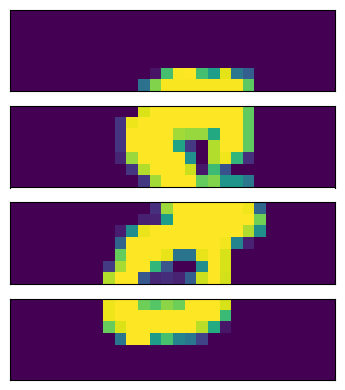

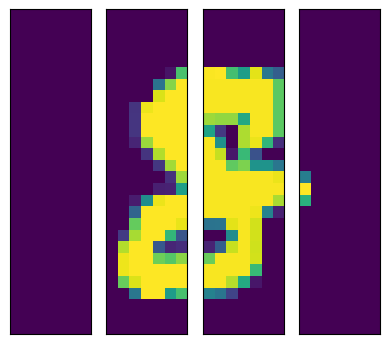

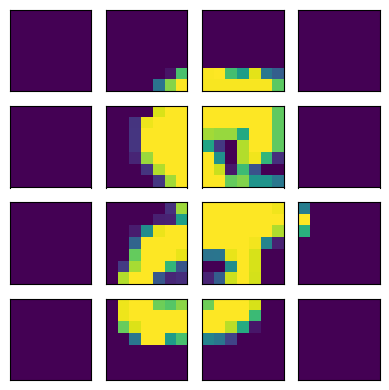

In [8]:
# cut into horizontal strips
horizontal = einops.rearrange(images, 'b c (k h) w -> b k c h w', k=4)
plot(horizontal[0], figsize=(8, 4), n_col=1)
# cut into vertical strips
vertical = einops.rearrange(images, 'b c h (k w) -> b k c h w', k=4)
plot(vertical[0], figsize=(4, 8))
# cut into tiles
tile_size = 7
tiles = einops.rearrange(images, 'b c (h t1) (w t2) -> b (h w) c t1 t2', t1=tile_size, t2=tile_size)
plot(tiles[0], n_col=4, block_size=1)

## encoder

In [9]:
N_HEADS = 1
N_BLOCKS = 2
VOCAB_SIZE = 10
EMBED_SIZE = 16
HIDDEN_SIZE = 32
IMG_SIZE = 28
CHANNEL = 1
TILE_SIZE = 7
assert IMG_SIZE % TILE_SIZE == 0
CONTEXT_SIZE = 1 + (IMG_SIZE // TILE_SIZE) ** 2
LEARNING_RATE = 3e-4
DROPOUT = 0.1

In [10]:
def get_sinusoidal_positional_encoding(context_size=CONTEXT_SIZE, embed_size=EMBED_SIZE):
  position = torch.arange(context_size).unsqueeze(1)
  div_term = torch.exp(torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size))
  positional_encoding = torch.zeros(context_size, embed_size)
  positional_encoding[:, 0::2] = torch.sin(position * div_term)
  positional_encoding[:, 1::2] = torch.cos(position * div_term)
  return positional_encoding.to(device)

In [11]:
activations = {}

class Positional(Enum):
  NONE = auto()
  SINUSOIDAL = auto()
  LEARNED = auto()

class MultiheadAttention(nn.Module):
  def __init__(self, n_heads, embed_size, positional, dropout, n_block=0):
    super().__init__()
    assert embed_size % n_heads == 0, f'{embed_size=} should be divisible by {n_heads=}'
    self.n_heads = n_heads
    self.embed_size = embed_size
    self.positional = positional
    self.dropout_rate = dropout
    self.n_block = n_block
    self.qkv = nn.Linear(embed_size, embed_size * 3, bias=False) # generate Q, K, V all at once
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(embed_size)

  def forward(self, x):
    B, C, E = x.shape
    # pre-layernorm
    x = self.ln(x)
    q, k, v = self.qkv(x).chunk(3, dim=-1)
    # split heads
    q = q.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    k = k.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    v = v.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    # by hand
    correlation = q @ k.transpose(-2, -1)
    correlation = correlation / math.sqrt(k.shape[-1])
    correlation = F.softmax(correlation, dim=-1)
    activations[self.n_block] = correlation.detach()
    correlation = F.dropout(correlation, p=self.dropout_rate, training=self.training)
    y = correlation @ v
    # combine heads
    y = y.transpose(1, 2).contiguous().view(B, C, self.embed_size)
    y = self.dropout(y)
    return y

class Block(nn.Module):
  def __init__(self, positional, n_heads, embed_size, hidden_size, dropout, n_block):
    super().__init__()
    self.block = n_block
    self.attention = MultiheadAttention(n_heads, embed_size, positional=positional, dropout=dropout, n_block=n_block)
    self.ff = nn.Sequential(
      nn.LayerNorm(embed_size), # pre-layernorm
      nn.Linear(embed_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, embed_size),
      nn.Dropout(dropout)
    )

  def forward(self, x):
    x = x + self.attention(x)
    x = x + self.ff(x)
    return x

class Net(nn.Module):
  def __init__(self, positional=Positional.LEARNED, n_heads=N_HEADS, n_blocks=N_BLOCKS, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE, context_size=CONTEXT_SIZE, dropout=DROPOUT, tile_size=TILE_SIZE):
    super().__init__()
    self.positional = positional
    self.context_size = context_size
    self.tile_size = tile_size
    # net
    if positional == Positional.SINUSOIDAL: self.positional_embedding = get_sinusoidal_positional_encoding()
    elif positional == Positional.LEARNED: self.positional_embedding = nn.Embedding(context_size, embed_size)      
    else: self.positional_embedding = torch.tensor(0.).to(device)
    self.tile_embedding = nn.Linear(TILE_SIZE * TILE_SIZE * CHANNEL, embed_size)
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
    self.blocks = nn.Sequential(*[Block(positional, n_heads, embed_size, hidden_size, dropout, i) for i in range(n_blocks)])
    self.head = nn.Linear(embed_size, vocab_size)

  def forward(self, x):
    # (batch_size, channel, height, width)
    # split into tiles/patches/chunks
    x = einops.rearrange(x, 'b c (h t1) (w t2) -> b (h w) (c t1 t2)', t1=self.tile_size, t2=self.tile_size)
    # embed
    x = self.tile_embedding(x)
    # add cls token
    cls_token = self.cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    # positional encoding
    x = x + self.get_positional_embedding()
    # attention and ff
    x = self.blocks(x)
    # head
    x = self.head(x)
    # only look at first token:
    x = x[:, 0, :]
    return x
  
  def get_positional_embedding(self):
    if self.positional == Positional.LEARNED:
      return self.positional_embedding(torch.arange(0, self.context_size).to(device))
    return self.positional_embedding

## train

In [12]:
model = Net(positional=Positional.LEARNED, n_heads=1, n_blocks=2).to(device)

In [32]:
def train(model, epochs, lr=LEARNING_RATE, do_log=True, log_every=1):
  model.train()
  opt = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in tqdm(range(epochs)):
    for X, Y in data:
      X, Y = X.to(device), Y.to(device)
      out = model(X)
      loss = F.cross_entropy(out, Y)
      opt.zero_grad()
      loss.backward()
      opt.step()
    if do_log and epoch % log_every == 0:
      print(f'{epoch:5} {loss.item()}')

train(model, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

    0 0.23382984101772308
    1 0.11656459420919418
    2 0.10125605016946793
    3 0.11283817887306213
    4 0.13406218588352203
    5 0.07572723180055618
    6 0.050447121262550354
    7 0.21180517971515656
    8 0.13576488196849823
    9 0.08161057531833649
   10 0.13713930547237396
   11 0.1735255867242813
   12 0.12358894944190979
   13 0.10351476073265076
   14 0.07546748965978622
   15 0.28030678629875183
   16 0.1692264825105667
   17 0.12150406837463379
   18 0.5198782086372375
   19 0.06831980496644974
   20 0.0773037001490593
   21 0.20818661153316498
   22 0.05818869173526764
   23 0.16500107944011688
   24 0.145308718085289
   25 0.09883908182382584
   26 0.10925372689962387
   27 0.10480017215013504
   28 0.2521746754646301
   29 0.20851004123687744
   30 0.27052101492881775
   31 0.14196015894412994
   32 0.06452163308858871
   33 0.13059531152248383
   34 0.17680716514587402
   35 0.054641544818878174
   36 0.09087416529655457
   37 0.14860038459300995
   38 0.167027473

In [37]:
_ = accuracy(model)
_ = accuracy(model, label='train')

accuracy on test : 0.9696999788284302
accuracy on train: 0.9775333404541016


## checkpoint

In [34]:
# save
# ----
# torch.save(model.state_dict(), 'weights/MNIST-2layers-1head-500epochs.pt')

# load
# ----
# m = Net().to(device)
# m.load_state_dict(torch.load('weights/MNIST.pt'))

## visualizations

### visualize failures

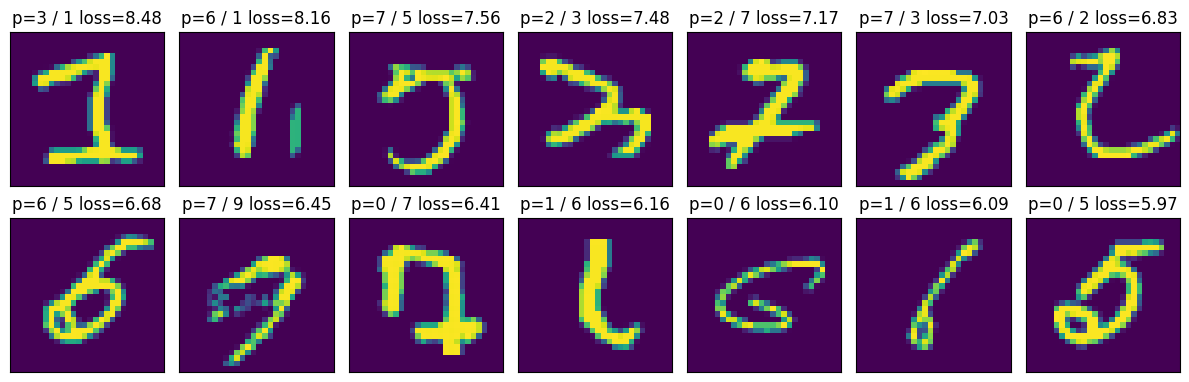

In [218]:
@torch.no_grad()
def failing(model, ds=data_test):
    model.eval()
    misslabeled_imgs = []
    losses = []
    wrong_labels = []
    real_labels = []
    for x, y in ds:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        out = logits.argmax(-1)
        losses.append(-logits.softmax(1)[torch.arange(logits.shape[0]), y].log()[out != y])
        misslabeled_imgs.append(x[out != y])
        wrong_labels.append(out[out != y])
        real_labels.append(y[out != y])
    return torch.cat(misslabeled_imgs), torch.cat(wrong_labels), torch.cat(real_labels), torch.cat(losses)

def sorted_failing(model, ds=data_test, descending=True):
    imgs, wrong_labels, real_labels, losses = failing(model, ds)
    order = losses.argsort(descending=descending)
    return imgs[order], wrong_labels[order], real_labels[order], losses[order]

def plot_failing(imgs, wrong_labels, real_labels, n_col=7, figsize=(12, 4)):
    fig, ax = plt.subplots(2, n_col, figsize=figsize)
    
    for i in range(imgs.shape[0]):
        idx = (i // n_col, i % n_col)
        img = imgs[i].cpu().permute(1, 2, 0)
        ax[idx].imshow(img)
        ax[idx].set_title(f'p={wrong_labels[i].item()} / {real_labels[i].item()} loss={losses[i].item():.2f}')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
    plt.tight_layout()
    plt.show()

misslabeled_imgs, wrong_labels, real_labels, losses = sorted_failing(model)
plot_failing(misslabeled_imgs[:14], wrong_labels[:14], real_labels[:14])

### confusion matrix

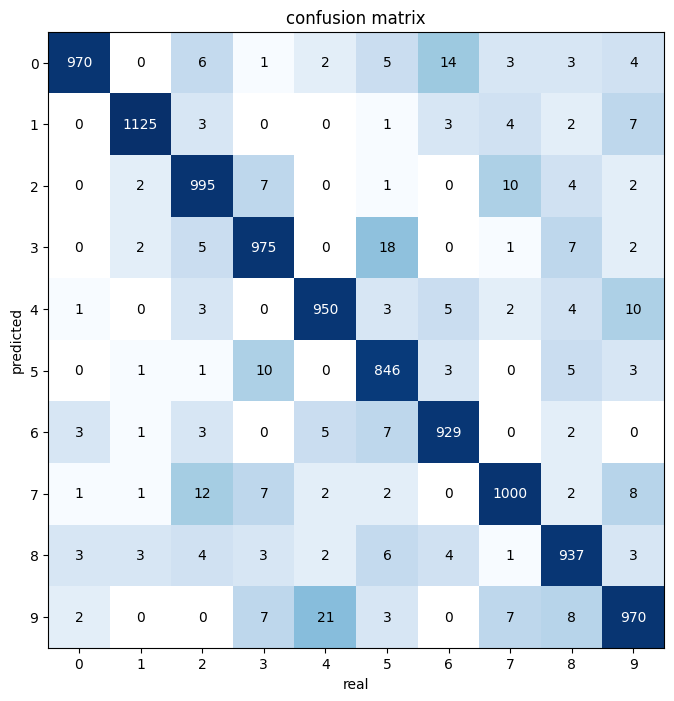

In [237]:
@torch.no_grad()
def label_all(model, ds=data_test):
    model.eval()
    predicted_labels = []
    real_labels = []
    for x, y in ds:
        x, y = x.to(device), y.to(device)
        out = model(x).argmax(-1)
        predicted_labels.append(out)
        real_labels.append(y)
    return torch.cat(predicted_labels), torch.cat(real_labels)

def to_confusion_matrix(predicted_labels, real_labels):
    confusion_matrix = torch.zeros((10, 10), dtype=torch.int32)
    for p, r in zip(predicted_labels, real_labels):
        confusion_matrix[p, r] += 1
    return confusion_matrix

def plot_confusion_matrix(confusion_matrix, figsize=(10, 8)):
    num_classes = confusion_matrix.shape[0]
    plt.figure(figsize=figsize)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues', norm=colors.LogNorm())
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, int(confusion_matrix[i, j]),
                    ha="center", va="center",
                    color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2. else "black")
    plt.title('confusion matrix')
    plt.ylabel('predicted')
    plt.xlabel('real')
    plt.xticks(np.arange(num_classes))
    plt.yticks(np.arange(num_classes))
    plt.show()

predicted_labels, real_labels = label_all(model)
confusion_matrix = to_confusion_matrix(predicted_labels, real_labels)
plot_confusion_matrix(confusion_matrix)

### visualize attention

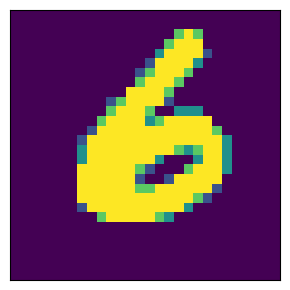

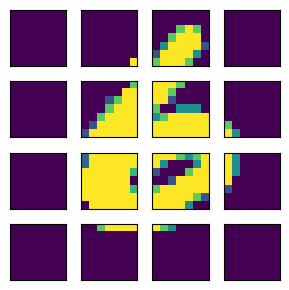

6


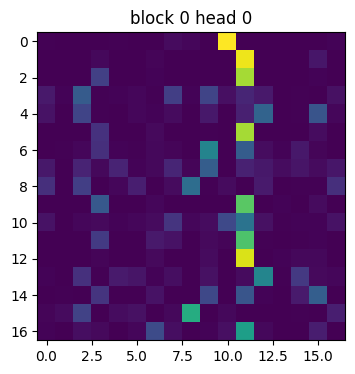

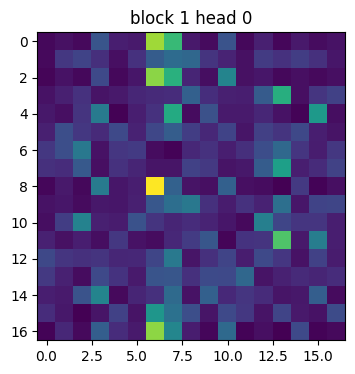

In [35]:
@torch.no_grad()
def visualize_attention(model, img):
    model.eval()
    plot(img)
    tiles = einops.rearrange(img, 'c (h t1) (w t2) -> (h w) c t1 t2', t1=TILE_SIZE, t2=TILE_SIZE)
    plot(tiles, n_col=4, block_size=0.75)
    img = img.to(device).unsqueeze(0)
    out = model(img).argmax(-1).item()
    print(out)

    for block, acts in activations.items():
        if acts.dim() == 4:
            acts = acts.squeeze(0)
        repeat = acts.shape[0]
        fig, ax = plt.subplots(1, repeat, figsize=(12, 4))
        if repeat == 1: ax = np.array([ax])
        for i in range(repeat):
            ax[i].imshow(acts[i].cpu())
            ax[i].set_title(f'block {block} head {i}')

visualize_attention(model, next(iter(data))[0][0])

### visualize positional embeddings

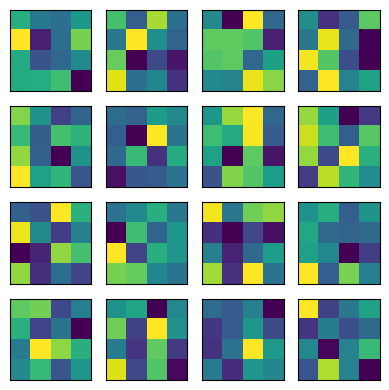

In [36]:
@torch.no_grad()
def visualize_positional_embeddings(emb):
    # strip cls token
    emb = emb[1:]
    emb = einops.rearrange(emb, 'n (k1 k2) -> n 1 k1 k2', k1=4)
    plot(emb, n_col=4, block_size=1)

visualize_positional_embeddings(model.get_positional_embedding())

### compare activations by groups

In [140]:
threes = [x for el, lab in data_test for x, y in zip(el, lab) if y == 3]
sevens = [x for el, lab in data_test for x, y in zip(el, lab) if y == 7]
heights = [x for el, lab in data_test for x, y in zip(el, lab) if y == 8]

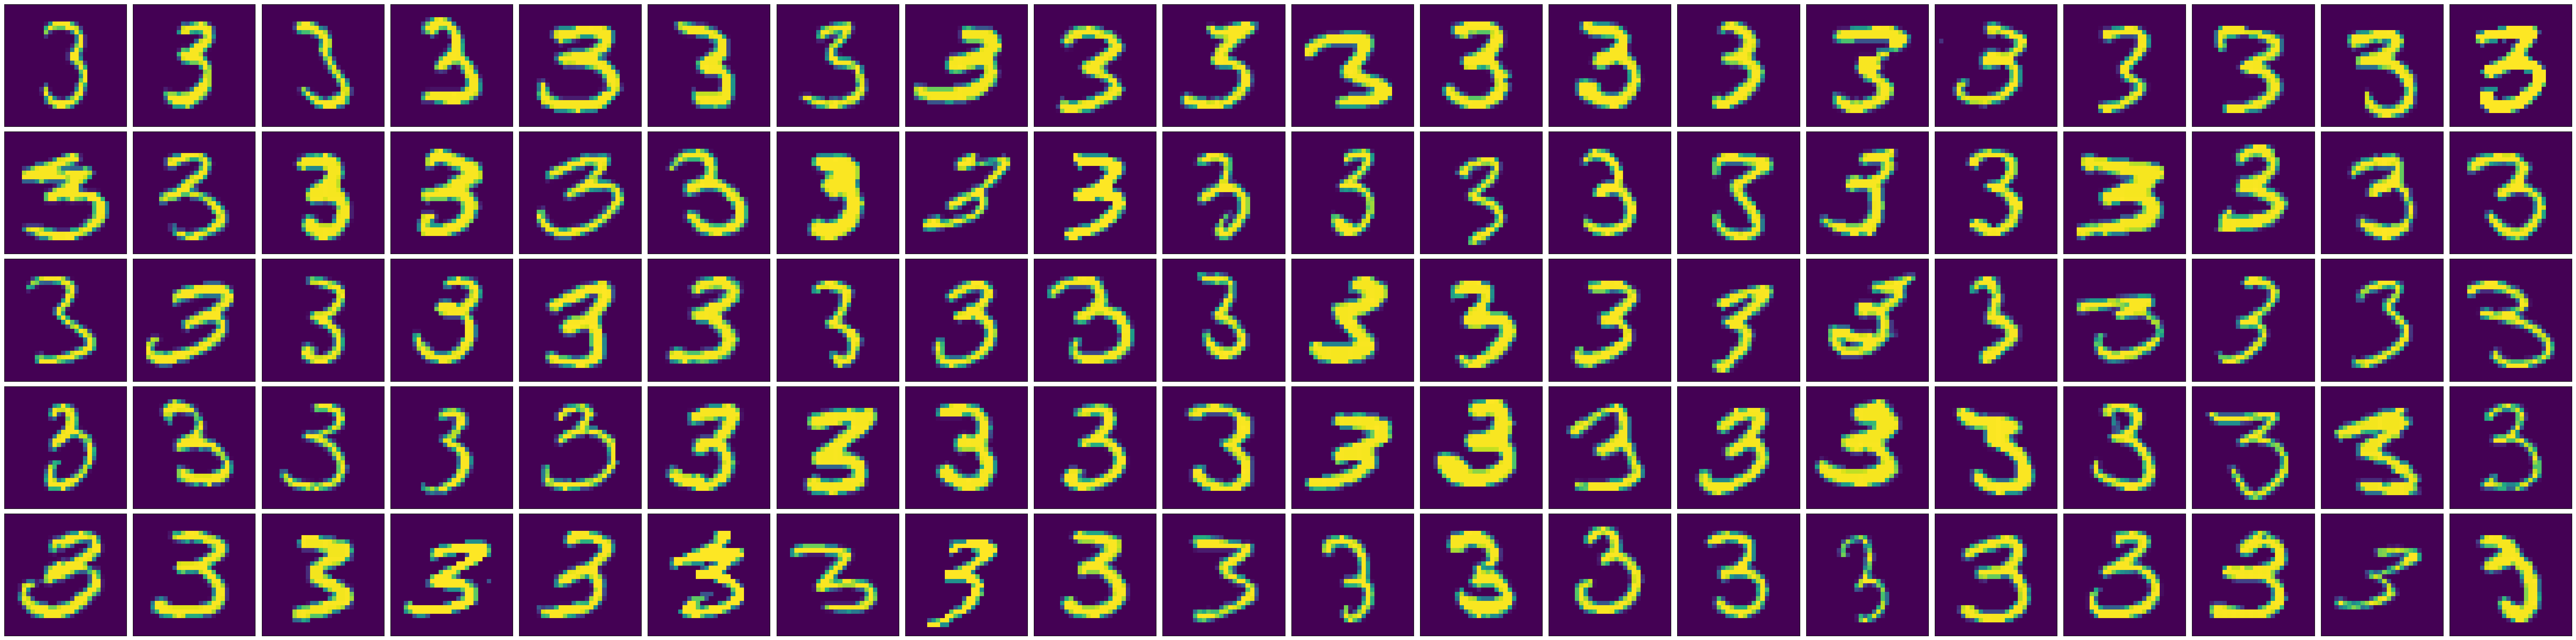

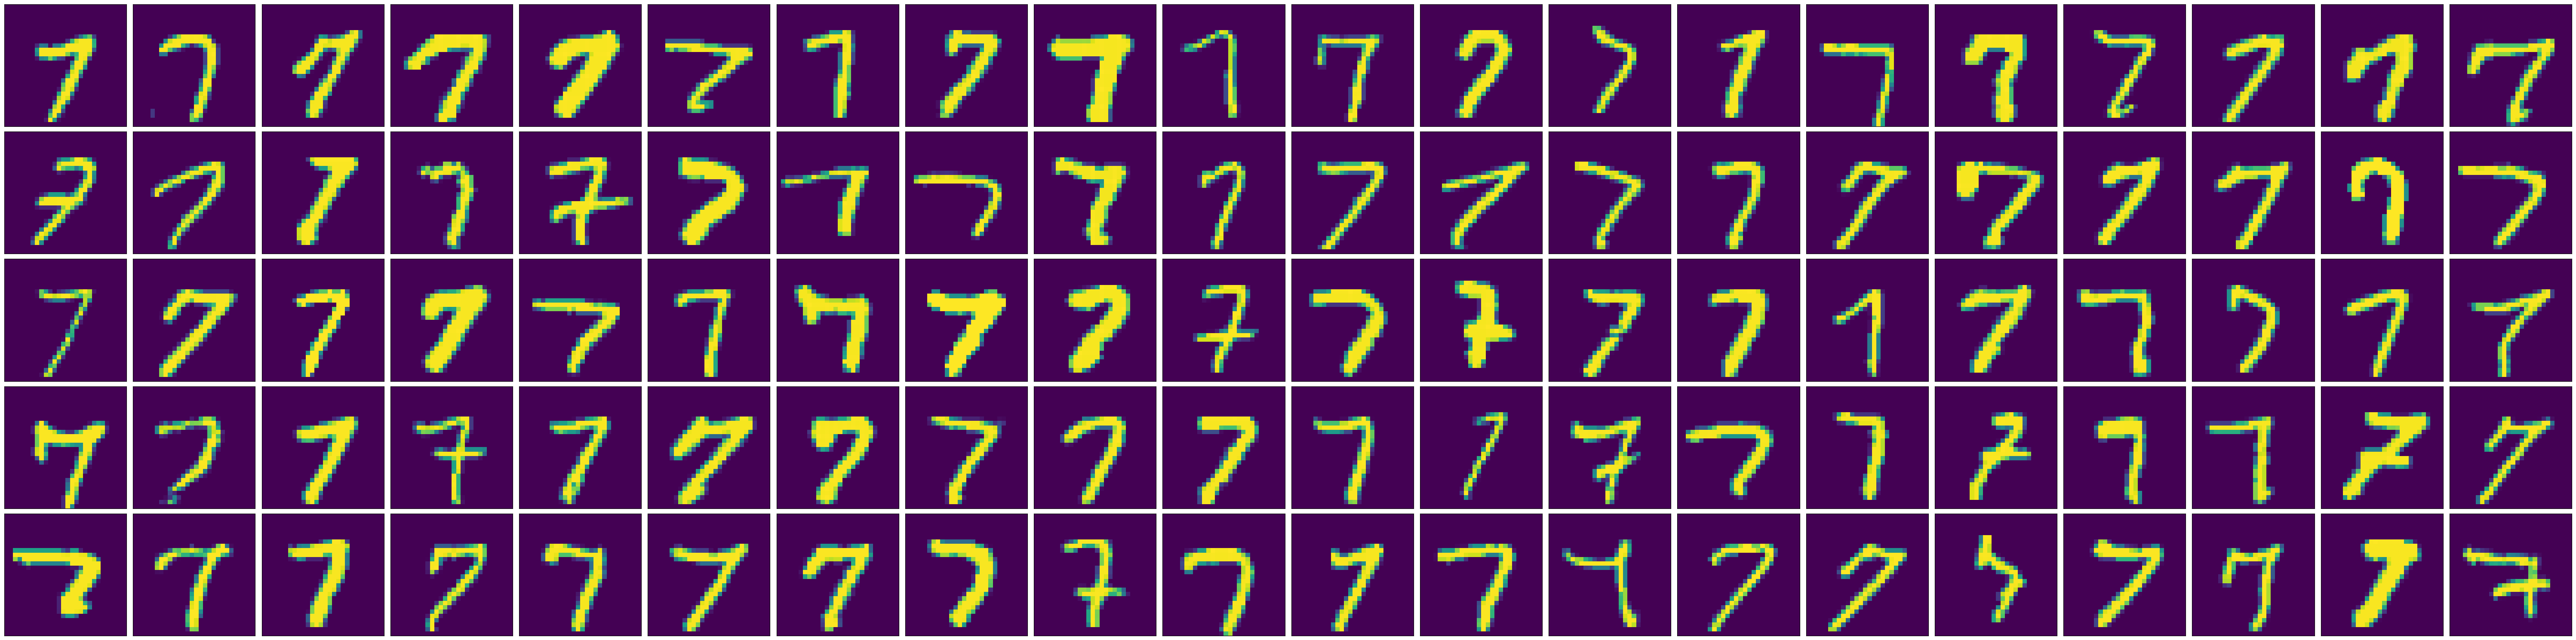

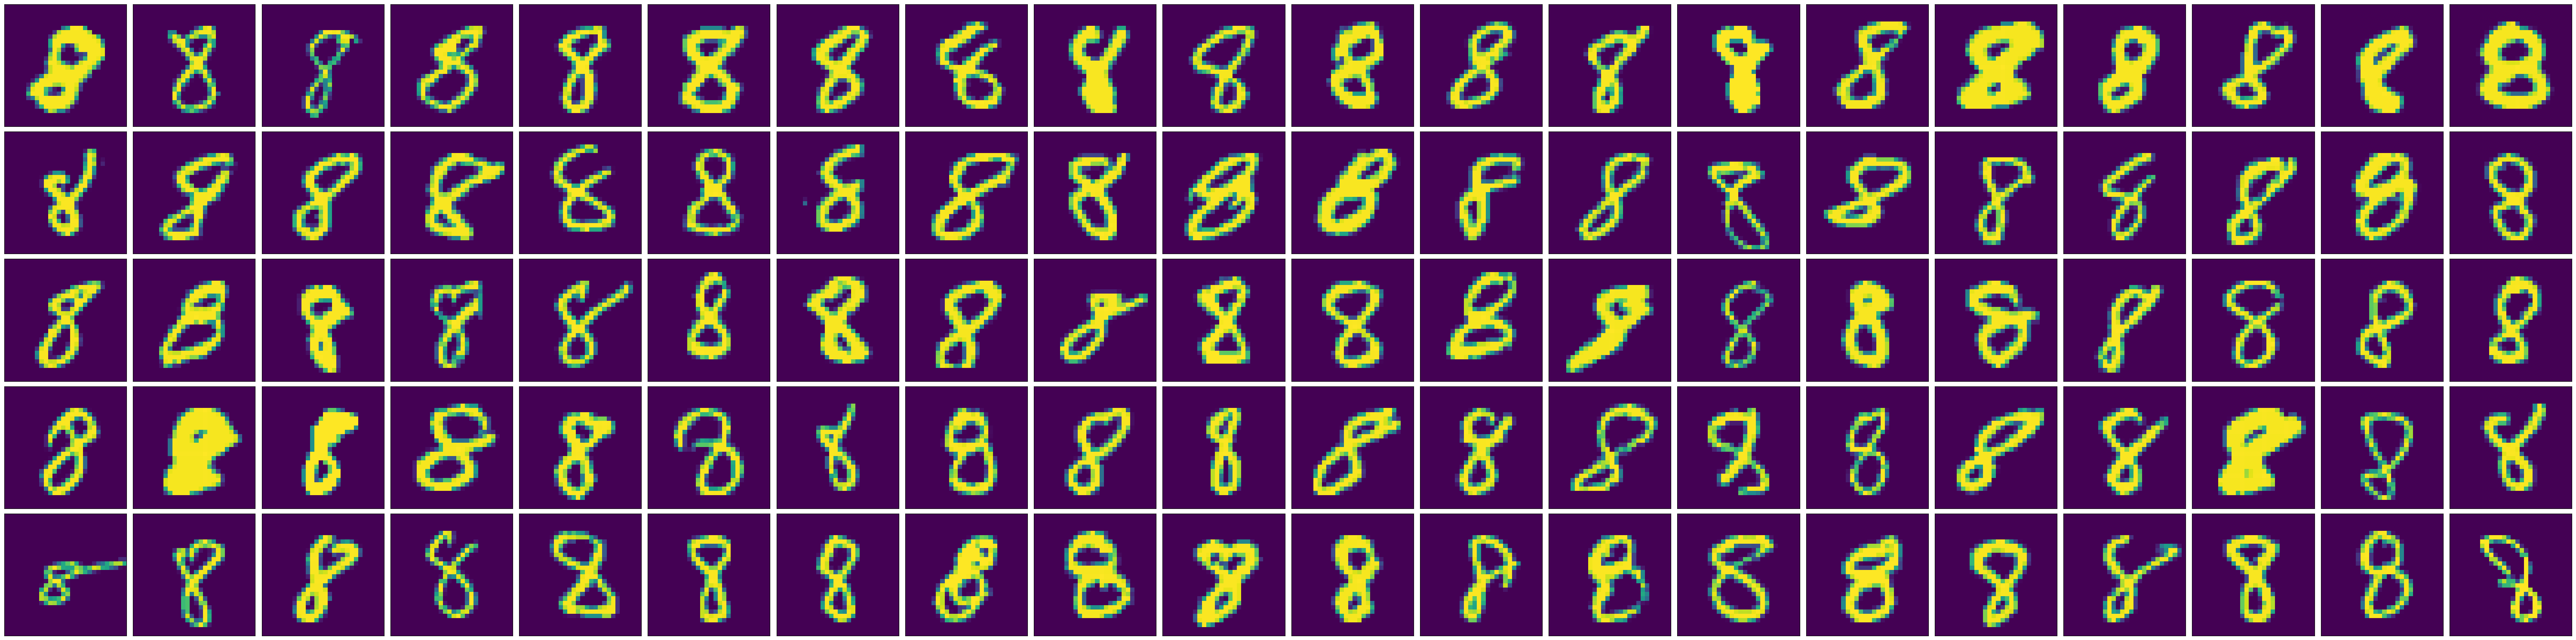

In [141]:
plot(threes[:100], n_col=20)
plot(sevens[:100], n_col=20)
plot(heights[:100], n_col=20)

In [143]:
@torch.no_grad()
def get_attention(model, imgs):
    model.eval()
    imgs = torch.stack(imgs).to(device)
    _ = model(imgs)
    return {x: y for x, y in activations.items()}

attentions_threes = get_attention(model, threes)
attentions_sevens = get_attention(model, sevens)
attentions_heights = get_attention(model, heights)

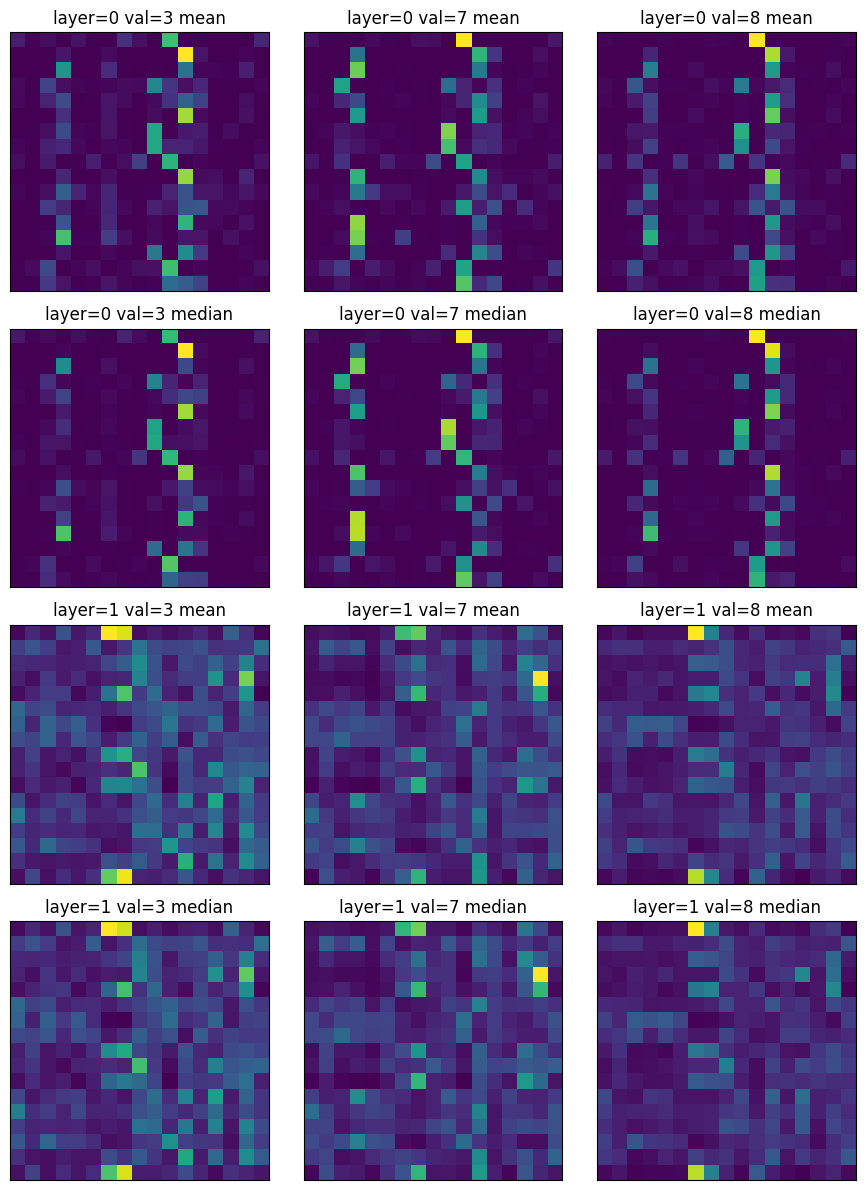

In [146]:
@torch.no_grad()
def compare_attention(attentions):
    visuals = []
    for layer, attention in attentions.items():
        mean_attention = attention.mean(dim=0)
        median_attention = attention.median(dim=0).values
        visuals.append(mean_attention)
        visuals.append(median_attention)
    return visuals

vis1 = compare_attention(attentions_threes)
vis2 = compare_attention(attentions_sevens)
vis3 = compare_attention(attentions_heights)
plot(*zip(vis1, vis2, vis3), n_col=3, labels=[
    'layer=0 val=3 mean', 'layer=0 val=7 mean', 'layer=0 val=8 mean',
    'layer=0 val=3 median', 'layer=0 val=7 median', 'layer=0 val=8 median',
    'layer=1 val=3 mean', 'layer=1 val=7 mean', 'layer=1 val=8 mean',
    'layer=1 val=3 median', 'layer=1 val=7 median', 'layer=1 val=8 median',
    ])

### visualize heatmap

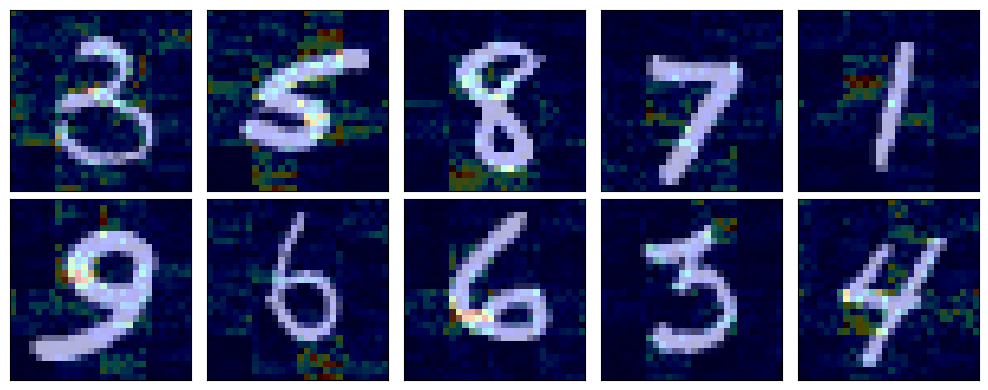

In [185]:
def heatmap(model, imgs, labels):
    model.eval()
    imgs = imgs.to(device).requires_grad_()
    labels = labels.to(device)
    out = model(imgs)
    loss = F.cross_entropy(out, labels)
    imgs.grad = None
    loss.backward()
    return imgs.grad

def plot_heatmap(imgs, grads, n_col=1, figsize=(10, 4)):
    n_row = math.ceil(imgs.shape[0] / n_col)
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([[ax]])
    elif n_row == 1: ax = ax.reshape((1, -1))
    elif n_col == 1: ax = ax.reshape((-1, 1))
    for i in range(imgs.shape[0]):
        idx = (i // n_col, i % n_col)
        ax[idx].imshow(imgs[i].cpu().permute(1, 2, 0), cmap='gray')
        ax[idx].imshow(grads[i].cpu().permute(1, 2, 0), cmap='jet', alpha=0.3)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
    plt.tight_layout()
    plt.show()

imgs, labels = next(iter(data_test))
imgs, labels = imgs[:10], labels[:10]
grads = heatmap(model, img, label).abs()
plot_heatmap(imgs, grads, n_col=5)